In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import pyarrow.parquet as pq
import sys
import torch
import random
import torch.nn as nn
import torch.nn.functional as F
import math
from IPython.display import clear_output
import logging
from pathlib import Path

import matplotlib.pyplot as plt
sys.path.append('../../../')

from configs.data_configs.physionet_contrastive import data_configs
from configs.model_configs.mTAN.physionet import model_configs
from src.models.mTAND.model_mtan import EncMtanRnnClassification, MegaNetClassifier
from src.data_load.dataloader import create_data_loaders, create_test_loader
from src.trainers.trainer_mTAND import MtandTrainer


from src.create_embeddings import create_embeddings

from src.data_load import split_strategy
from src.data_load.data_utils import prepare_data
from src.data_load.splitting_dataset import (
    ConvertingTrxDataset,  # TargetDataset
    DropoutTrxDataset,
    SplittingDataset,
    TargetEnumeratorDataset,
)
from src.models.preprocessors import FeatureProcessor, TimeConcater
from src.data_load.dataloader import collate_splitted_rows, padded_collate
from torch.utils.data import DataLoader

from sklearn.linear_model import LogisticRegression
from einops import repeat, rearrange, reduce


/home/event_seq/experiments/physionet/notebooks/../../../src/trainers/base_trainer.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# s = "{((16, 32), 0.0, 32): 0.7662219684385382, ((16, 32), 0.0, 64): 0.7434982350498338, ((16, 32), 0.0, 128): 0.7607843646179402, ((16, 32), 0.2, 32): 0.7754749792358805, ((16, 32), 0.2, 64): 0.7730092400332225, ((16, 32), 0.2, 128): 0.7624454941860463, ((16, 32), 0.3, 32): 0.7773177948504983, ((16, 32), 0.3, 64): 0.7958757267441862, ((16, 32), 0.3, 128): 0.7598889119601329, ((16, 32), 0.4, 32): 0.7742810423588039, ((16, 32), 0.4, 64): 0.7823401162790699, ((16, 32), 0.4, 128): 0.7746444144518272, ((16, 32, 64), 0.0, 32): 0.7508046096345515, ((16, 32, 64), 0.0, 64): 0.7575659260797343, ((16, 32, 64), 0.0, 128): 0.7360231519933556, ((16, 32, 64), 0.2, 32): 0.7214493355481727, ((16, 32, 64), 0.2, 64): 0.7737749169435216, ((16, 32, 64), 0.2, 128): 0.76671511627907, ((16, 32, 64), 0.3, 32): 0.7636783637873754, ((16, 32, 64), 0.3, 64): 0.7767078488372093, ((16, 32, 64), 0.3, 128): 0.7794331395348837, ((16, 32, 64), 0.4, 32): 0.7469892026578072, ((16, 32, 64), 0.4, 64): 0.7633409468438539, ((16, 32, 64), 0.4, 128): 0.7774605481727574, ((16, 64), 0.0, 32): 0.7501816860465116, ((16, 64), 0.0, 64): 0.7505839908637874, ((16, 64), 0.0, 128): 0.7950451619601329, ((16, 64), 0.2, 32): 0.769764846345515, ((16, 64), 0.2, 64): 0.7818339908637874, ((16, 64), 0.2, 128): 0.7795499377076412, ((16, 64), 0.3, 32): 0.7646387043189369, ((16, 64), 0.3, 64): 0.7941237541528239, ((16, 64), 0.3, 128): 0.7736581187707642, ((16, 64), 0.4, 32): 0.7553337832225914, ((16, 64), 0.4, 64): 0.7831057931893688, ((16, 64), 0.4, 128): 0.7500389327242525, ((16, 64, 128), 0.0, 32): 0.7427714908637874, ((16, 64, 128), 0.0, 64): 0.7736840739202657, ((16, 64, 128), 0.0, 128): 0.7508694975083058, ((16, 64, 128), 0.2, 32): 0.658624896179402, ((16, 64, 128), 0.2, 64): 0.7475342607973423, ((16, 64, 128), 0.2, 128): 0.773982558139535, ((16, 64, 128), 0.3, 32): 0.6219308035714287, ((16, 64, 128), 0.3, 64): 0.7642234219269103, ((16, 64, 128), 0.3, 128): 0.7825088247508306, ((16, 64, 128), 0.4, 32): 0.5932049418604651, ((16, 64, 128), 0.4, 64): 0.774968853820598, ((16, 64, 128), 0.4, 128): 0.7812110672757474}"
# dic = eval(s)
# for key,v in dic.items():
#     print("TC_{}_TR_1H_1L_DRP_{}_GRU_{}H".format(key[0], key[1], key[2]))
# for key,v in dic.items():
#     print(v)

In [3]:
conf = data_configs()
model_conf = model_configs()

In [4]:
from src.trainers.sampling_strategies import get_sampling_strategy

In [5]:
model_conf.get('loss.neg_count')

5

In [6]:
ss = get_sampling_strategy(model_conf)

In [5]:
train_loader, valid_loader = create_data_loaders(conf)


0it [00:00, ?it/s]

3200it [00:00, 4851.44it/s]


In [6]:
for batch in train_loader:
    break

In [11]:
batch[0].payload['event_time'][:5]

tensor([[ 0.0583,  0.0688,  0.0896,  0.1104,  0.1146,  0.1208,  0.1250,  0.1313,
          0.1479,  0.1521,  0.1729,  0.1938,  0.2146,  0.2354,  0.2375,  0.2396,
          0.2562,  0.2625,  0.2667,  0.2771,  0.2875,  0.3187,  0.3292,  0.3312,
          0.3396,  0.3417,  0.3500,  0.3604,  0.3812,  0.3833, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -

In [17]:
k = 256
ns = np.arange(10,512, 10)

flops = []
for n in ns:
    flops.append((4*n**2) - (6*k*n))

In [18]:
import matplotlib.pyplot as plt

Text(384, 10000.0, '384')

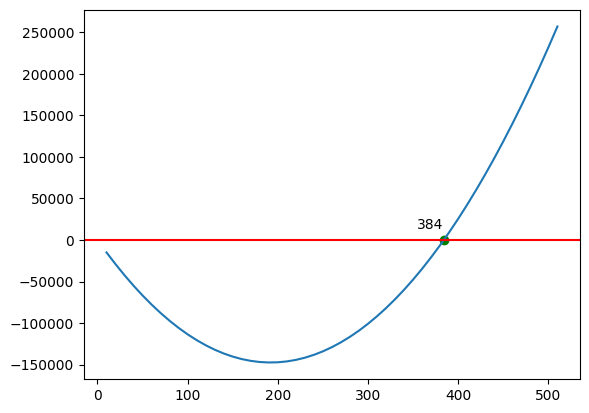

In [28]:
plt.plot(ns, flops)
plt.scatter(384, 0, color='green')
plt.axhline(y=0, color='r')
plt.text(384, 0+1e4, '384', ha='right', va='bottom')

/tmp/ipykernel_418634/2807482426.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  smw = nn.functional.softmax(smw)


In [40]:
smw = torch.rand(5)
smw = nn.functional.softmax(smw)
logp = torch.log(smw)
entropy1 = torch.sum(-smw*logp)
entropy1

/tmp/ipykernel_418634/2482953204.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  smw = nn.functional.softmax(smw)


tensor(1.5895)

In [39]:
torch.log(torch.tensor(5))

tensor(1.6094)

In [12]:
positive_pairs, negative_pairs = ss.get_pairs(embedding, batch[1][0])

In [13]:
negative_pairs

tensor([[  0, 307],
        [  1, 333],
        [  2, 525],
        ...,
        [637, 614],
        [638,  75],
        [639, 431]])

In [14]:
from src.trainers.losses import ContrastiveLoss, get_loss

In [15]:
cl = get_loss(model_conf, ss)

In [16]:
cl(embedding, batch[1][0])

tensor(6837.2266)

In [33]:


class B():
    def __init__(self):
        print('inited B')

class A(B):
    def __init__(self, a):
        super().__init__()
        print('A inited', a)

class C(A):

    def __init__(self, a):
        super().__init__(a)

In [34]:
C('hello')

inited B
A inited hello


In [8]:
processor = FeatureProcessor(model_conf=model_conf, data_conf=conf)

time_blocks = [16, 32]

#mtc = MultipleTimeSum(time_blocks)

tc1 = TimeConcater(time_blocks[0], 'cpu')

blocks2 = torch.linspace(0., 1., 33)
tc2 = TimeConcater(time_blocks[1], 'cpu')

In [9]:
x, time_steps = processor(batch[0])

In [10]:
x1, time_steps = tc1(x, time_steps)

In [11]:
x2, time_steps = tc2(x, time_steps)

In [12]:
x1.size(), x2.size()

(torch.Size([64, 16, 62]), torch.Size([64, 32, 62]))

In [26]:
x1_repeated = torch.repeat_interleave(x1, 2, dim=1).unsqueeze(0)

In [27]:
x1_repeated.size(), x2.size()

(torch.Size([1, 64, 32, 62]), torch.Size([64, 32, 62]))

In [49]:
w = torch.ones(2)
w[0] = 2

In [28]:
features = torch.cat([x1_repeated, x2.unsqueeze(0)], dim=0)

In [50]:
w1 = repeat(w, 'nb -> nb bs l d', bs=64, l=32, d=62)

In [51]:
w.size()

torch.Size([2])

In [ ]:
(features * w.repeat(62, 64, 32, 1).transpose(0,3)) == (features * w1)

In [53]:
(features * w1).size()

torch.Size([2, 64, 32, 62])

In [88]:
class MultiTimeSummator(nn.Module):

    def __init__(self, time_blocks, device):
        super().__init__()

        assert isinstance(time_blocks, list)

        self.time_ps = []
        for num_block in time_blocks:
            self.time_ps.append(TimeConcater(num_block, device))

        self.max_len = max(time_blocks)

        self.weights = nn.Parameter(torch.ones(len(time_blocks)))


    def forward(self, x, time_steps):
        new_xs = self.collect_new_x(x, time_steps)

        nb, bs, l, d = new_xs.size()
        
        cur_w = repeat(self.weights, 'nb -> nb bs l d', bs=bs, l=l, d=d)
        
        out = (new_xs * cur_w).sum(dim=0)

        return out


    def collect_new_x(self, x, time_steps):

        new_xs = []

        for tc in self.time_ps:
            cur_multiplier = self.max_len // tc.num_points
            out_x, time_steps = tc(x, time_steps)
            new_x = torch.repeat_interleave(out_x, cur_multiplier, dim=1).unsqueeze(0)

            new_xs.append(new_x)

        return torch.cat(new_xs, dim=0)

In [89]:
mts = MultiTimeSummator([16, 32, 64], 'cpu')

In [90]:
mts.weights

Parameter containing:
tensor([1., 1., 1.], requires_grad=True)

In [74]:
new_x = mts(x, time_steps)

RuntimeError: Tensor type unknown to einops <class 'NoneType'>

In [71]:
list(mts.parameters())

[Parameter containing:
 tensor([1., 1., 1.], requires_grad=True)]

In [67]:
new_x.size()

torch.Size([64, 64, 62])

In [141]:
seq_proc = nn.Sequential(FeatureProcessor(model_conf=model_conf, data_conf=conf), 
                         TimeConcater(blocks))

In [142]:
x, t = seq_proc(batch[0])

TypeError: TimeConcater.forward() missing 1 required positional argument: 'time_steps'

In [132]:
tc = TimeConcater(blocks)

In [133]:
new_x = tc(x, time_steps)

In [134]:
new_x.size()

torch.Size([128, 9, 62])

In [61]:
k = 10
d = 10

p= d*(k-1)//2
conv = nn.Conv1d(62, 3, kernel_size=k, dilation=d, padding=p)

In [62]:
out = conv(x.transpose(1,2))

In [63]:
out.size()

torch.Size([128, 3, 128])

In [77]:
norm = getattr(nn, 'Identity')

In [80]:
norm(64)

Identity()

In [81]:
class Net(nn.Module):

    def __init__(self):
        super().__init__()

        in_dim = 62
        out_dim = 3
        hid_gru = 7
        kernels = [3,5,9]
        dilations = [1,5,9]

        res_dim = out_dim * (len(kernels) * len(dilations))

        self.convs = nn.ModuleList()
        for k in kernels:
            for d in dilations:
                p = d * (k - 1) // 2
                self.convs.append(nn.Conv1d(in_dim, out_dim, kernel_size=k, padding=p, dilation=d))

        self.gru = nn.GRU(
            res_dim,
            hid_gru,
            batch_first=True
        )
        self.out_linear = nn.Linear(hid_gru, 2)
    def forward(self, x):
        out = torch.concat([conv(x.transpose(1,2)) for conv in self.convs], dim=1)
        print(out.size())
        all_hiddens, _ = self.gru(out.transpose(1,2))
        out = self.out_linear(all_hiddens[:,-1])
        return out

In [82]:
net = Net()

In [83]:
out = net(x)

torch.Size([128, 27, 128])


In [74]:
out.size()

torch.Size([128, 2])

In [15]:
encoder_layer = nn.TransformerEncoderLayer(d_model=62, nhead=2)
transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=3)

In [16]:
out = transformer_encoder(x)

In [18]:
gru = nn.GRU(
    62,
    33, 
    batch_first=True
)

In [19]:
gru_out = gru(out)

In [21]:
gru_out[0].size()

torch.Size([128, 128, 33])

In [22]:
lens = batch[0].seq_lens - 1


In [25]:
out[:, lens, :].diagonal().T.size()

torch.Size([128, 62])

In [27]:
gru_out[0][:, lens, :].diagonal().T.size()

torch.Size([128, 33])

In [4]:
test = pd.read_parquet(conf.test_path)

In [9]:
df['target'].value_counts(), test['target'].value_counts()

(target
 0.0    2758
 1.0     442
 Name: count, dtype: int64,
 target
 0.0    688
 1.0    112
 Name: count, dtype: int64)

In [12]:
np.intersect1d(test['user'].values, df['user'].values)

array([], dtype=int32)

<Axes: >

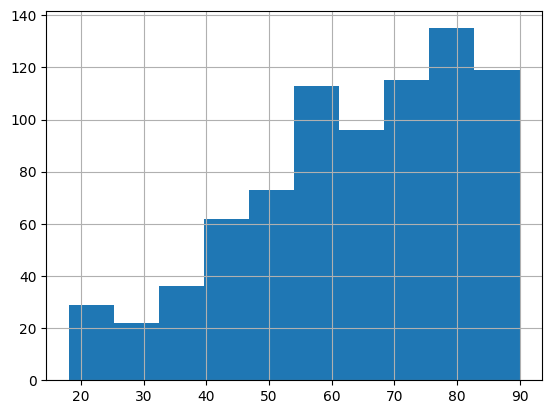

In [19]:
test['Age'].apply(lambda x: x[0]).hist()

<Axes: >

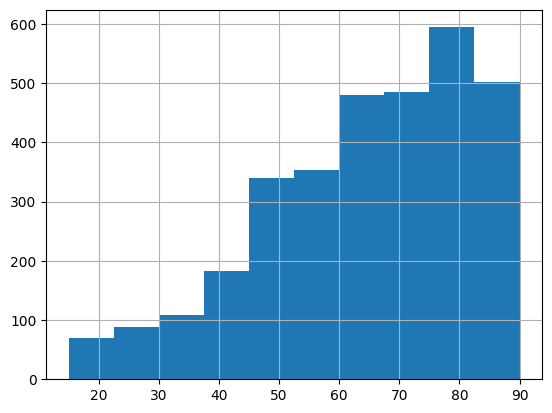

In [20]:
df['Age'].apply(lambda x: x[0]).hist()

In [5]:
train_data, valid_data = prepare_data(conf)

train_dataset = SplittingDataset(
    train_data,
    split_strategy.create(**conf.train.split_strategy),
    conf.features.target_col,
)
train_dataset = TargetEnumeratorDataset(train_dataset)
# train_dataset = TargetDataset(train_dataset)
train_dataset = ConvertingTrxDataset(train_dataset)
# не уверен что нам нужна история с дропаутом точек.
# Но это выглядит неплохой аугментацией в целом
train_dataset = DropoutTrxDataset(
    train_dataset, trx_dropout=conf.train.dropout, seq_len=conf.train.max_seq_len
)

0it [00:00, ?it/s]

3200it [00:00, 3209.23it/s]


In [6]:
batch = [train_dataset[0], train_dataset[14]]

In [32]:
for i in range(50):
    if train_dataset[i][0][1][1].item() == 1:
        break

In [1]:
batch

NameError: name 'batch' is not defined

In [45]:
import functools
import operator
from collections import defaultdict
from typing import Dict

import torch
from torch.utils.data import DataLoader



In [46]:

class PaddedBatch:
    def __init__(self, payload: Dict[str, torch.Tensor], length: torch.LongTensor):
        self._payload = payload
        self._length = length

    @property
    def payload(self):
        return self._payload

    @property
    def seq_lens(self):
        return self._length

    def __len__(self):
        return len(self._length)

    def to(self, device, non_blocking=False):
        length = self._length.to(device=device, non_blocking=non_blocking)
        payload = {
            k: v.to(device=device, non_blocking=non_blocking)
            for k, v in self._payload.items()
        }
        return PaddedBatch(payload, length)  # type: ignore


def padded_collate(batch):
    new_x_ = defaultdict(list)
    for x, _ in batch:
        for k, v in x.items():
            new_x_[k].append(v)

    lengths = torch.LongTensor([len(e) for e in next(iter(new_x_.values()))])

    new_x = {
        k: torch.nn.utils.rnn.pad_sequence(v, batch_first=True)
        for k, v in new_x_.items()
    }
    new_idx = torch.tensor([y[0] for _, y in batch])
    new_y = torch.tensor([y[1] for _, y in batch])

    return PaddedBatch(new_x, lengths), torch.cat(
        [new_idx.unsqueeze(0), new_y.unsqueeze(0)], dim=0
    )


def collate_splitted_rows(batch):
    # flattens samples in list of lists to samples in list
    batch = functools.reduce(operator.iadd, batch)
    return padded_collate(batch)

In [47]:
collate_splitted_rows(batch)[1][1]

tensor([0, 1])

In [21]:
train_loader, valid_loader = create_data_loaders(conf)
#test_loader = create_test_loader(conf)

346it [00:00, 3459.24it/s]

3200it [00:00, 5060.75it/s]


In [22]:
for batch in train_loader:
    break

In [25]:
batch[0].payload['Albumin'].size()

torch.Size([128, 128])

In [28]:
batch[0].payload['event_time'][:,-1]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.9979, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

In [33]:
torch.sin(torch.tensor(0))

tensor(0.)

In [30]:
lens = batch[0].seq_lens - 1

In [38]:
len(lens)

128

In [23]:
x = torch.rand(128, 121, 32)

In [62]:
lens.unsqueeze(0).unsqueeze(2).repeat(1, 1, 32)[0,0,:]

tensor([64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64,
        64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64])

In [53]:
gathered = torch.gather(x, 1, lens.unsqueeze(0).unsqueeze(2).repeat(1, 1, 32))

In [55]:
gathered.size()

torch.Size([1, 128, 32])

In [54]:
gathered[0,2,:]

tensor([0.1384, 0.8533, 0.3297, 0.7942, 0.0402, 0.5267, 0.6776, 0.4334, 0.2273,
        0.7756, 0.1255, 0.2925, 0.0079, 0.8984, 0.2342, 0.3943, 0.6500, 0.5439,
        0.5401, 0.4058, 0.8818, 0.3804, 0.2495, 0.0518, 0.5949, 0.9953, 0.1699,
        0.1753, 0.4296, 0.2453, 0.8269, 0.8425])

In [52]:
x[2,lens[2], :]

tensor([0.7498, 0.4410, 0.3366, 0.5427, 0.2153, 0.9919, 0.6954, 0.9410, 0.5704,
        0.5550, 0.9509, 0.9612, 0.5235, 0.2092, 0.9685, 0.8754, 0.2760, 0.7941,
        0.1731, 0.4050, 0.4290, 0.7468, 0.6349, 0.4570, 0.9743, 0.3449, 0.1059,
        0.8301, 0.5587, 0.4942, 0.7697, 0.7323])

In [73]:
x[:,lens,:].diagonal().T

torch.Size([128, 32])

In [75]:
lstm = torch.nn.LSTM(input_size = 32, hidden_size=43)

In [77]:
x = torch.rand(16, 5, 32)
ah, _ = lstm(x)

In [80]:
_

(tensor([[[ 0.0732,  0.0801,  0.1020, -0.1204,  0.1263, -0.0383, -0.0513,
            0.1629, -0.0234, -0.0594,  0.1264,  0.0807,  0.0056,  0.3168,
            0.0027,  0.0530, -0.0199,  0.1594, -0.1713,  0.0037, -0.2926,
           -0.0428, -0.1936, -0.0696,  0.0179, -0.1299, -0.1307, -0.1598,
            0.1620, -0.0957, -0.0266, -0.1717, -0.0192, -0.0705, -0.1929,
           -0.2732,  0.1136, -0.1260, -0.0935,  0.4427,  0.0504, -0.0657,
           -0.1135],
          [ 0.0098,  0.0720,  0.1105, -0.1589,  0.0432, -0.1394,  0.0343,
            0.2303,  0.0189, -0.1476,  0.1567,  0.0541,  0.0124,  0.3682,
            0.0339,  0.0963, -0.0829,  0.2176, -0.1656,  0.0037, -0.3031,
           -0.1526, -0.2040, -0.0300, -0.0073, -0.1798, -0.1283, -0.1340,
            0.3248, -0.1298, -0.1057, -0.1499,  0.0022, -0.0942, -0.2724,
           -0.2618,  0.0081, -0.0987, -0.0293,  0.4103,  0.0689, -0.0648,
           -0.1318],
          [ 0.0353,  0.1024,  0.1028, -0.1193,  0.0437, -0.0645, -0.16

In [8]:
%load_ext autoreload
%autoreload 2

from src.models.mTAND.base_models import SimpleClassifier, FeatureProcessor

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
fp = FeatureProcessor(model_conf=model_conf, data_conf=conf)

In [10]:
f = fp(batch[0])

torch.Size([256, 122, 38]) torch.Size([256, 122, 24])


In [11]:
f[0].size()

torch.Size([256, 122, 62])

In [7]:
net = SimpleClassifier(model_conf=model_conf, data_conf=conf)

In [8]:
net = net.to(model_conf.device)

In [16]:
def perform_epoch(model, batch, optimizer):
    optimizer.zero_grad()
    out = model(batch[0])
    loss = model.loss(out, batch[1])
    loss['total_loss'].backward()
    optimizer.step()

    return loss

def train(model, loader, val_loader, optimizer, num_epochs):

    model.train()
    for epoch in range(num_epochs):
        for i, batch in tqdm(enumerate(loader), total=len(loader)):
            loss = perform_epoch(model, batch, optimizer)
        
        validate(model, val_loader)

def validate(model, val_loader):

    model.eval()
    pred = []
    y_true = []
    with torch.no_grad():
        for batch in tqdm(val_loader):
            out = model(batch[0])
            pred.append(out.)

16

In [ ]:
lr = 3e-3
net = SimpleClassifier(model_conf=model_conf, data_conf=conf)
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
train(net, train_loader, optimizer, 10)

In [19]:
batch[0].payload['Age'].size()

torch.Size([16, 125])

In [9]:
out = net(batch[0])

torch.Size([1, 16, 32])


In [20]:
out.size()

torch.Size([16, 2])

In [25]:
out.argmax(dim=1).size()

torch.Size([16])

In [22]:
loss_fn = nn.CrossEntropyLoss()

In [23]:
loss_fn(out, batch[1][1])

tensor(0.7712, grad_fn=<NllLossBackward0>)

In [21]:
for param in net.parameters():
    print(param.name)
    print(param.grad.detach)

None
<built-in method detach of Tensor object at 0x7fd8e0bddfd0>
None
<built-in method detach of Tensor object at 0x7fd7d415ede0>
None
<built-in method detach of Tensor object at 0x7fd4d1d6e3e0>
None
<built-in method detach of Tensor object at 0x7fd8e0b9d8f0>
None
<built-in method detach of Tensor object at 0x7fd8e0b6ba10>
None
<built-in method detach of Tensor object at 0x7fd8e0b9e430>
None
<built-in method detach of Tensor object at 0x7fd8e0bde020>
None
<built-in method detach of Tensor object at 0x7fd8e0bde0c0>
None
<built-in method detach of Tensor object at 0x7fd4baa6b740>
None


AttributeError: 'NoneType' object has no attribute 'detach'

In [6]:
chkp_path = '../data/test_chkp.pth'
chkp = {}
chkp['model'] = net.state_dict()
torch.save(chkp, chkp_path)

In [16]:
out = net(batch[0])

In [18]:
losses = net.loss(out)

In [19]:
losses

{'elbo_loss': tensor(1488891.7500, grad_fn=<AddBackward0>),
 'kl_loss': tensor(4.6083, grad_fn=<MeanBackward0>),
 'recon_loss': tensor(1488891.2500, grad_fn=<MeanBackward0>),
 'total_CE_loss': tensor(6.5203, grad_fn=<SumBackward0>),
 'total_loss': tensor(1488895., grad_fn=<AddBackward0>),
 'Gender': tensor(2.2982, grad_fn=<MeanBackward0>),
 'ICUType': tensor(2.0160, grad_fn=<MeanBackward0>),
 'MechVent': tensor(2.2061, grad_fn=<MeanBackward0>)}

In [6]:
create_embeddings(conf, model_conf)

7200it [00:02, 3347.82it/s]
800it [00:00, 6348.51it/s]
100%|██████████| 90/90 [00:02<00:00, 31.14it/s]


valid embeds saved


100%|██████████| 200/200 [00:05<00:00, 36.33it/s]


test embeds saved


100%|██████████| 1710/1710 [00:40<00:00, 41.73it/s]


train embeds saved


In [7]:
train_embeds = pd.read_csv(conf.train_embed_path, index_col=0)
test_embeds = pd.read_csv(conf.test_embed_path, index_col=0)



In [25]:
train_y = pd.read_parquet(conf.train_path)[conf.features.target_col]
test_y = pd.read_parquet(conf.test_path)[conf.features.target_col].astype(int)

In [26]:
train = train_embeds.join(train_y)
train = train.dropna()
train[conf.features.target_col] = train[conf.features.target_col].astype(int)

test = test_embeds.join(test_y)

In [37]:
from lightgbm import LGBMClassifier

In [39]:
params = {
    "n_estimators": 500,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "subsample": 0.5,
    "subsample_freq": 1,
    "learning_rate": 0.02,
    "feature_fraction": 0.75,
    "max_depth": 6,
    "lambda_l1": 1,
    "lambda_l2": 1,
    "min_data_in_leaf": 50,
    "random_state": 42,
    "n_jobs": 8,
    "reg_alpha": None,
    "reg_lambda": None,
    "colsample_bytree": None,
    "min_child_samples": None
}

In [40]:
model = LGBMClassifier(**params)

In [41]:
model.fit(train.drop(columns=[conf.features.target_col]), train[conf.features.target_col])

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 2474, number of negative: 2026
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001982 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 4500, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.549778 -> initscore=0.199773
[LightGBM] [Info] Start training from score 0.199773
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

LGBMClassifier(colsample_bytree=None, feature_fraction=0.75, lambda_l1=1,
               lambda_l2=1, learning_rate=0.02, max_depth=6, metric='auc',
               min_child_samples=None, min_data_in_leaf=50, n_estimators=500,
               n_jobs=8, objective='binary', random_state=42, reg_alpha=None,
               reg_lambda=None, subsample=0.5, subsample_freq=1)

In [42]:
y_pred = model.predict(test.drop(columns=[conf.features.target_col]))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [43]:
from sklearn.metrics import accuracy_score, roc_auc_score

In [44]:
roc_auc_score(test_y, y_pred)

0.49788132100047816

In [27]:
ckpt = torch.load(chkp_path)
net.load_state_dict(ckpt["model"])

In [36]:
batch[1]

tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3])

In [49]:
split_strategy_dict = {
    "split_strategy": "NoSplit"
}
train_data, valid_data = prepare_data(conf)

train_dataset = SplittingDataset(
    train_data,
    split_strategy.create(**split_strategy_dict),
    # conf.features.target_col,
)
train_dataset = TargetEnumeratorDataset(train_dataset)
# train_dataset = TargetDataset(train_dataset)
train_dataset = ConvertingTrxDataset(train_dataset)
# не уверен что нам нужна история с дропаутом точек.
# Но это выглядит неплохой аугментацией в целом


train_loader = DataLoader(
    dataset=train_dataset,
    shuffle=True,
    collate_fn=collate_splitted_rows,
    num_workers=conf.train.num_workers,
    batch_size=conf.train.batch_size,
)

0it [00:00, ?it/s]

9717it [00:00, 13852.25it/s]


In [14]:
with torch.no_grad():
    train_embeddings = []
    ids = []
    for batch in tqdm(train_loader):
        out = net(batch[0])
        embeddings = out['z'].view(4, -1)
        train_embeddings.append(embeddings)
        ids.append(batch[1])

100%|██████████| 2308/2308 [00:31<00:00, 74.11it/s]


In [17]:
all_embeds = torch.cat(train_embeddings)
all_indices = torch.cat(ids)

In [21]:
all_embeds.size()

torch.Size([9232, 32])

In [22]:
pd.DataFrame(data=all_embeds.numpy(), index=all_indices.numpy())

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
7443,0.102797,1.169541,0.019089,-0.514786,-1.388183,0.961653,-0.590597,-0.262099,0.144197,1.172947,...,1.550775,1.656553,-1.211777,0.713178,-0.422202,0.057362,-0.811645,-0.603588,-0.488893,0.160870
8096,0.803449,1.956381,0.596296,0.496732,0.486962,-1.346716,-1.141745,0.070024,-1.569932,-0.472612,...,-0.723514,0.423374,-1.114043,2.086276,-2.363746,1.266546,-0.149737,-0.264849,-0.322092,-1.082480
3679,-0.002727,-1.473100,1.137815,0.073783,0.528109,-0.423857,-0.033820,0.668729,1.464864,-1.710192,...,-0.659925,-0.128479,-0.790339,1.412809,0.014140,0.823128,-0.271114,0.360713,0.073781,1.201015
7751,0.523437,-1.091199,0.383193,-0.536097,0.407316,0.998033,-1.337681,-0.492494,-0.177824,0.827958,...,0.050278,-0.186300,-0.929536,0.382475,0.188110,-0.039815,-0.135864,0.371854,-0.226536,-1.075974
1058,-0.090836,0.931548,0.487700,1.544706,0.134991,-0.388189,-0.351403,0.690511,0.369822,-0.996384,...,0.037646,0.474755,0.105620,1.116618,0.331259,-0.752344,-1.333730,0.134372,-1.005091,-0.208797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5050,0.647142,0.396011,-1.058875,1.620824,-2.104278,0.130711,0.205906,1.588393,-0.809435,0.058372,...,0.256889,-0.805244,-1.666883,-0.457891,-0.153310,1.100958,-0.033816,-0.539116,-0.516178,0.900175
7619,-0.387352,0.407266,0.045567,1.079472,0.276017,0.598434,0.116289,-0.153847,-0.532574,-0.304695,...,-0.291467,0.979066,-2.529730,-0.883053,-0.234192,1.234930,-0.504991,0.397301,-1.507193,-1.275558
4744,-0.665543,1.066480,0.286753,0.817286,-1.457128,0.637894,0.323675,1.191625,-0.373805,-0.026182,...,-0.252915,0.829856,2.367053,1.139469,-0.526248,0.331766,-0.604189,0.403450,-2.052348,-1.497805
8663,0.188203,-0.145553,0.806009,-0.384668,-0.735343,-0.895407,-1.491430,1.100353,1.275650,0.737131,...,-0.490947,-1.864704,-0.011014,-0.212244,0.133844,0.649861,0.691730,-0.337050,-0.022557,0.339424


In [29]:
criterion = nn.CrossEntropyLoss(reduction='none')

In [22]:
out_dist = torch.rand(20, 4, 100)

In [23]:
target = torch.rand(20, 1, 100)

In [15]:
out_dist.view(-1, 4).size()

torch.Size([2000, 4])

In [33]:
criterion(out_dist, target.squeeze(1).long(), ).sum(dim=1).mean()

tensor(141.1932)

In [47]:
loss_out = net.loss(out)

In [16]:
loss_out

{'elbo_loss': tensor(12326.9258, grad_fn=<AddBackward0>),
 'kl_loss': tensor(0.5898, grad_fn=<MeanBackward0>),
 'recon_loss': tensor(12326.8672, grad_fn=<MeanBackward0>)}

In [18]:
trainer = MtandTrainer(
    model=net,
    optimizer=torch.optim.Adam(net.parameters(), lr=3e-4),
    train_loader=train_loader,
    val_loader=valid_loader,
    total_iters=50,
    iters_per_epoch=20,
    ckpt_dir="./ckpt",
    ckpt_replace=True,
    ckpt_track_metric="loss",
    metrics_on_train=True,
)

In [19]:
trainer.run()

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

In [20]:
def perform_epoch(model, batch, optimizer):
    optimizer.zero_grad()
    out = model(batch[0])
    loss = model.loss(out)
    loss['elbo_loss'].backward()
    optimizer.step()

    return loss

def train(model, loader, optimizer, num_epochs):

    model.train()
    recon_loss = []
    kl_loss = []
    for epoch in range(num_epochs):
        for i, batch in tqdm(enumerate(loader), total=len(loader)):
            loss = perform_epoch(model, batch, optimizer)
            recon_loss.append(loss['recon_loss'].detach().item())
            kl_loss.append(loss['kl_loss'].detach().item())

            if (i+1) % 1 == 0:
                plot_losses(recon_loss, kl_loss)


def plot_losses(recon_loss, kl_loss):
    clear_output(True)
    plt.plot(np.log(recon_loss), color='g', label='recon')
    plt.plot(kl_loss, color='r', label='kl')
    plt.legend()   
    plt.show() 

In [21]:
lr = 3e-4
net = MegaNet(model_conf=model_conf, data_conf=conf)
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
train(net, train_loader, optimizer, 10)

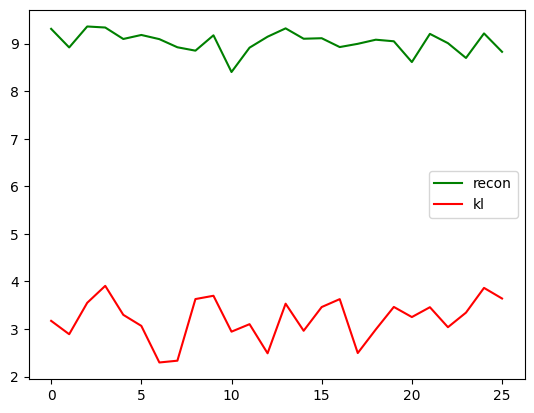

  1%|          | 26/2308 [00:07<11:32,  3.30it/s]


KeyboardInterrupt: 